In [1]:
#%matplotlib inline
%matplotlib widget

In [2]:
# initialization
from rayoptics.environment import *
from rayoptics.mpl.analysisfigure import Wavefront, RayFanPlot, RayGeoPSF, AnalysisFigure
from rayoptics.gui import dashboards

from matplotlib import gridspec
import matplotlib.colors as mcolors

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

# Create a new model

In [3]:
app = AppManager(None)
opm = app.model = OpticalModel()
sm = opm.seq_model
osp = opm.optical_spec
pm = opm.parax_model

### Define first order aperture and field for system

In [4]:
pupil_diameter = 40.
pupil_radius = pupil_diameter/2
osp.pupil = PupilSpec(osp, key=['object', 'pupil'], value=pupil_diameter)

# single field on-axis
osp.field_of_view = FieldSpec(osp, key=['object', 'angle'], flds=[0.0])

# wavelength for analysis: 550nm
osp.spectral_region = WvlSpec([(550.0, 1.0)], ref_wl=0)

### object at infinity, i.e. collimated input

In [5]:
sm.gaps[0].thi = 1e+11

### setup aperture stop surface, then offset mirror behind the aperture stop

In [6]:
mirror_offset = srf.DecenterData(DecenterType.REV, y=pupil_radius)
opm.add_dummy_plane(sd=pupil_radius, decenter=mirror_offset)
sm.set_stop();

### add parabolic mirror and enable it to tip, tilt and offset

In [7]:
offset_aperture = srf.Circular(radius=pupil_diameter, y_offset=0.)
#offset_aperture = srf.Circular(radius=pupil_radius, y_offset=pupil_radius)
mirror_perturb = srf.DecenterData(DecenterType.DAR)
opm.add_mirror(power=1/80, cc=-1, t=-80, sd=pupil_diameter,
               decenter=mirror_perturb, clear_apertures=[offset_aperture])

### all of the system data has been entered, update the model

In [8]:
opm.update_model()

In [9]:
sm.list_sg()

              c               mode        type        y       alpha
                      t           medium
 Obj:      0.00000                 
                1.00000e+11          air
Stop:      0.00000                         REV     20.000     0.0000
                    0.00000          air
   2:  -0.00625000          reflect        DAR     0.0000     0.0000
                   -80.0000          air
 Img:     -0.00000                 


# List first order data

In [10]:
pm.first_order_data()

efl                  80
ffl                 -80
pp1                  -0
bfl                  80
ppk                   0
f/#                   2
m                     0
red           -1.25e+09
obj_dist          1e+11
obj_ang               1
enp_dist             -0
enp_radius           20
na obj            2e-10
n obj                 1
img_dist            -80
img_ht            1.396
exp_dist             -0
exp_radius           20
na img           0.2425
n img                -1
optical invariant       0.3491


# Draw a lens picture

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

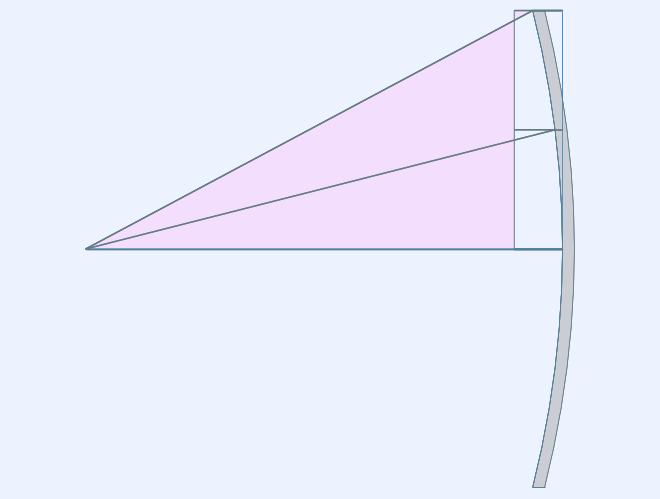

In [11]:
isdark = False
layout_plt = plt.figure(FigureClass=InteractiveLayout, opt_model=opm, refresh_gui=app.refresh_gui,
                        do_draw_rays=True, do_paraxial_layout=False, is_dark=isdark).plot()

app.add_figure(layout_plt)

In [12]:
fld, wvl, foc = osp.lookup_fld_wvl_focus(0)

In [13]:
optical_axis_ray = trace_base(opm, [0., 0.], fld, wvl)
list_ray(optical_axis_ray)

            X            Y            Z           L            M            N               Len
  0:      0.00000      0.00000            0     0.000000     0.000000     1.000000        1e+11
  1:      0.00000      0.00000            0     0.000000     0.000000     1.000000        -1.25
  2:      0.00000     20.00000        -1.25     0.000000    -0.246154    -0.969231        81.25
  3:      0.00000      0.00000            0     0.000000    -0.246154    -0.969231            0


## Use the built-in Spot Diagram plot

In [14]:
spot_plt = plt.figure(FigureClass=SpotDiagramFigure, opt_model=opm, scale_type=Fit.User_Scale,
                      user_scale_value=0.1, is_dark=isdark).plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Add tilt to mirror

In [15]:
#sm.ifcs[2].decenter.euler[0] = 0.00573  # 0.1 mrad mirror tilt
sm.ifcs[2].decenter.euler[0] = 0.0573  # 1 mrad mirror tilt
opm.update_model()

### Redo Spot diagram with tilted mirror

In [16]:
spot_plt = plt.figure(FigureClass=SpotDiagramFigure, opt_model=opm, scale_type=Fit.User_Scale,
                      user_scale_value=0.025, is_dark=isdark).plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [17]:
image_pt, ref_dir, ref_sphere_radius = fld.ref_sphere

In [18]:
image_pt

array([ 0.        , -0.16389492,  0.        ])

In [19]:
fld.ref_sphere[0][1]=0

In [20]:
image_pt

array([0., 0., 0.])

In [21]:
wavefront_plt = plt.figure(FigureClass=WavefrontFigure, opt_model=opm, scale_type=Fit.User_Scale,
                 user_scale_value=50., is_dark=isdark).plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Start of dynamic dashboard

## Set up the reference image point for the aberration calculations.

    Use the central ray from the on axis field point and take it's coordinates on the image interface as the definition for the on-axis image point

In [22]:
ctr_ray = trace_base(opm, [0., 0.], fld, wvl)

img_offset = ctr_ray[0][-1][0]
on_axis_pt = np.array([img_offset[0], img_offset[1]])

## Set up the data sources for the plots.

### RayGrid

    Used to trace and manage a grid of rays at a specific field and wavelength,
        specifically to construct a grid representation of a wavefront.
    grid_pkg attribute contains all of the ray data in the grid (all surfaces)
    grid attribute contains the opd and the pupil coord values

### RayList

    Used to trace an arbitrary list of rays at a specific field and wavelength
        specifically to collect the ray coordinates on the (defocused) image plane
    ray_list attribute contains all of the ray data in the list (all surfaces)
    ray_abr attribute contains the x and y aberration values with respect to the
    (defocused) image_pt_2d

In [23]:
ray_grid = analyses.RayGrid(opm, f=fld, wl=wvl, image_pt_2d=on_axis_pt)
ray_list = analyses.RayList(opm, num_rays=48, f=fld, wl=wvl, image_pt_2d=on_axis_pt)

## Set up useful measures

    To control the sensitivity of the control widgets below, calculate magnitudes of 1 wave perturbations.

In [24]:
# one wave in system units
opd = opm.nm_to_sys_units(wvl)

# one wave of defocus
fod = osp.parax_data.fod
dfoc = opd/(fod.img_na**2/(2*fod.n_img))
qwrt_dfoc = abs(0.25*dfoc)

# one wave of tilt
_, _, ref_sphere_radius = fld.ref_sphere
shft = ref_sphere_radius*opd/fod.exp_radius

## Wavefront and Ray Aberration Display

In [25]:
fig = plt.figure(FigureClass=AnalysisFigure, data_objs=[ray_grid, ray_list],
                 figsize=[6, 6], is_dark=isdark)
gs = gridspec.GridSpec(nrows=2, ncols=3, figure=fig)

Wavefront(fig, gs[:2, :2], ray_grid, user_scale_value=None, do_contours=False, title='Wavefront Map',
          cmap="BrBG_r")
us = 0.01
scaler = mcolors.Normalize(vmin=0., vmax=80)
gPSF = RayGeoPSF(fig, gs[:1, -1:], ray_list, user_scale_value=us, scale_type='user', dsp_typ='hist2d',
                 yaxis_ticks_position='right', title='Geometrical PSF')
sPOT = RayGeoPSF(fig, gs[-1:, -1:], ray_list, user_scale_value=us, scale_type='user', dsp_typ='spot',
                 yaxis_ticks_position='right', title='Spot Diagram', marker='x')
fig.plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [26]:
defocus, x_shift, y_shift = dashboards.create_focus_dashboard([fig],
                                                              [ray_grid, ray_list],
                                                              osp.defocus.focus_shift, abs(dfoc), 0.2, on_axis_pt)
display(widgets.HBox([defocus, y_shift]))

## 2D Histogram and Spot Diagram

    This plot shows both a spot diagram and a 2D histogram display, using the same RayList instance as used above.

In [27]:
spotfig = plt.figure(FigureClass=AnalysisFigure, data_objs=[ray_list],
                 figsize=[9, 5], tight_layout=True, is_dark=isdark)
gs = gridspec.GridSpec(nrows=2, ncols=2, figure=spotfig)

us = 0.01
scaler = mcolors.Normalize(vmin=0., vmax=80)
gPSF = RayGeoPSF(spotfig, gs[:,:1], ray_list, user_scale_value=us, scale_type='user', dsp_typ='hist2d',
                 yaxis_ticks_position='left', title='Geometrical PSF', cmap='gray')
gPSF = RayGeoPSF(spotfig, gs[:,-1:], ray_list, user_scale_value=us, scale_type='user', dsp_typ='spot',
                 yaxis_ticks_position='right', title='Spot Diagram', marker='x')
spotfig.plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## 2D Histogram with x and y histogram slices

In [28]:
# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_hist2d = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(8, 8))

ax_hist2d = plt.axes(rect_hist2d)
ax_hist2d.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

# the scatter plot:
#ax_hist2d.scatter(x, y)
x_data = ray_list.ray_abr[0]
y_data = ray_list.ray_abr[1]
max_value = max(max(np.nanmax(x_data), -np.nanmin(x_data)),
                max(np.nanmax(y_data), -np.nanmin(y_data)))

bins = 30
edges = np.linspace(-max_value, max_value, num=100)
gamma = 0.3
dset = ax_hist2d.hist2d(*ray_list.ray_abr, bins=edges, norm=mcolors.PowerNorm(gamma))
h, xedges, yedges, qmesh = dset
ax_hist2d.set_facecolor(qmesh.cmap(0))

# now determine nice limits by hand:
binwidth = 0.0025
#lim = np.ceil(np.abs([x, y]).max() / binwidth) * binwidth
#ax_hist2d.set_xlim((-lim, lim))
#ax_hist2d.set_ylim((-lim, lim))

#bins = np.arange(-lim, lim + binwidth, binwidth)
centers = np.linspace(-max_value, max_value, num=99)
ax_histx.plot(centers, np.max(h, axis=1))
ax_histy.plot(np.max(h, axis=0), centers)

#ax_histx.set_xlim(ax_hist2d.get_xlim())
#ax_histy.set_ylim(ax_hist2d.get_ylim())

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## 2D Histogram with mirror tilt control

In [29]:
fig_hist = plt.figure(FigureClass=AnalysisFigure, data_objs=[ray_list],
                 figsize=[9, 5], tight_layout=True, is_dark=isdark)
gsh = gridspec.GridSpec(nrows=2, ncols=2, figure=fig_hist)

gPSF = RayGeoPSF(fig_hist, gsh[:,:], ray_list, user_scale_value=.01, scale_type='user', dsp_typ='hist2d',
                 title='Geometrical PSF')
fig_hist.refresh()

tilt_rng = 0.1146
tilt_rng = 100*shft/ref_sphere_radius
shift_rng = shft

alpha_tilt, x_dec, y_dec = dashboards.create_mirror_tilt_dashboard(sm.ifcs[2], app,
                                                                   [fig_hist], [ray_list],
                                                                   foc, tilt_rng, shift_rng,
                                                                   continuous_update=False)
display(widgets.HBox([alpha_tilt, x_dec, y_dec]))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Number of rays in the RayList instance

In [30]:
len(ray_list.ray_abr[0])

2233